# figure3b
based on `[20221108]EXP08-06a_embedding_tRNA`

In [1]:
#requirements
import h5py 
import sys 
sys.path.append("../../src")
import util
import torch 
import torch.nn as nn 
import numpy as np 
import random 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models.CMVAE import CovarianceModelVAE


def load_data_cm(path):
    data = h5py.File(path, "r")
    tr = torch.from_numpy(data["tr"][:]).nan_to_num(0).transpose(-2, -1).float()
    s = torch.from_numpy(data["s"][:]).transpose(-2, -1).float()
    p = torch.from_numpy(data["p"][:]).transpose(-2, -1).float()
    return tr, s, p

class MyDataset(Dataset):
    def __init__(self, path, weight_path = ""):
        super().__init__()
        self.path = path
        self.data = h5py.File(path, "r")
        self.tr = self.data["tr"]
        self.s = self.data["s"]
        self.p = self.data["p"]
        if weight_path != "":
            self.weight = h5py.File(weight_path, "r")["weight"][:]
            self.weight = self.weight.reshape(self.weight.size, 1)
        else:
            self.weight = np.ones(self.tr.shape[0])
            self.weight = self.weight.reshape(self.weight.size, 1)
                
    def __len__(self):
        return self.tr.shape[0]
    
    def __getitem__(self, index):
        tr_tensor = torch.from_numpy(self.tr[index]).nan_to_num(0).transpose(-2, -1).float()
        s_tensor = torch.from_numpy(self.s[index]).nan_to_num(0).transpose(-2, -1).float()
        p_tensor = torch.from_numpy(self.p[index]).nan_to_num(0).transpose(-2, -1).float()
        w_tensor = torch.from_numpy(self.weight[index]).float()

        return tr_tensor, s_tensor, p_tensor, w_tensor


In [2]:
# load trained model 

cfg = "../../outputs/ForLatent/RF00005/config_cmvae_07142.yaml"
ckpt = "../../outputs/ForLatent/RF00005/model_epoch41_cmvae_07142.pt"


config = util.load_config(cfg)
model = CovarianceModelVAE.build_from_config(cfg)
beta = config["BETA"]

model.load_model_from_ckpt(ckpt)
model.eval();


In [3]:
# load mutants info
h5_mutant = "../../datasets/ForDMSdata/RF00005_CCU/activity/Li2016_notrunc_traceback_onehot_cm.h5"
dataset = MyDataset(path = h5_mutant, weight_path = "")
dataloader = DataLoader(dataset, batch_size = config["BATCH_SIZE"], shuffle = False, num_workers = 4)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

dms_z = []
for step, tr_s_p_w in enumerate(dataloader, 0):
    tr, s, p, w  = tr_s_p_w
    tr = tr.to(model.device)
    s = s.to(model.device)
    p = p.to(model.device)
    w = w.to(model.device)

    mu, logvar = model.encoder((tr, s, p))
    dms_z.append(mu.detach().numpy())

dms_z = np.vstack(dms_z)
dms_z.shape


(65537, 16)

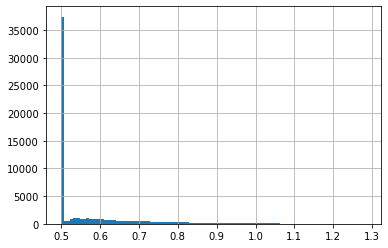

In [4]:
import pandas as pd

fitness = pd.read_table("../../datasets/ForDMSdata/RF00005_CCU/activity/FitnessData.txt", skiprows = 6)
# fitness = fitness[fitness["Fit"]>0.5]
fitness["Fit"].hist(bins = 100)

In [6]:
from sklearn.model_selection import train_test_split
train_id, test_id = train_test_split(fitness.index, test_size=0.3, random_state = 42)

SpearmanrResult(correlation=0.30113369702939136, pvalue=0.0)
(0.2931962474247102, 0.0)


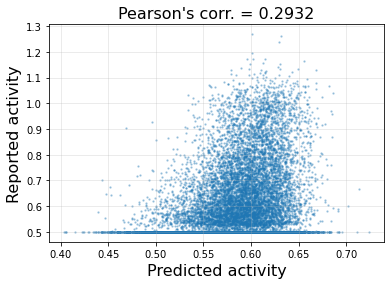

In [7]:
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "sans-serif"
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import spearmanr, pearsonr

# reg = LinearRegression().fit(dms_z[train_id], fitness["Fit"][train_id])

poly_features = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly_features.fit_transform(dms_z[train_id])
reg = LinearRegression()
reg.fit(X_poly, fitness["Fit"][train_id])
pred_test = reg.predict(poly_features.transform(dms_z[test_id]))

# plt.figure(figsize = (9, 6))

plt.grid(alpha = 0.3)

plt.scatter(
    pred_test,
    fitness["Fit"][test_id],
    s = 2, alpha = 0.3)

plt.xlabel("Predicted activity", fontsize = 16)
plt.ylabel("Reported activity", fontsize = 16)

# plt.hist2d(reg.predict(dms_z[test_id]), fitness["Fit"][test_id], bins = 10);
print(spearmanr(pred_test, fitness["Fit"][test_id]))
print(pearsonr(pred_test, fitness["Fit"][test_id]))

# corr, p = pearsonr(pred_test, fitness["Fit"][test_id])
corr, p = pearsonr(pred_test, fitness["Fit"][test_id])
plt.title(f"Pearson's corr. = {round(corr, 4)}", fontsize = 16)
plt.savefig(f"../../outputs/figures/figure3b.png", dpi = 300, transparent = True)
plt.savefig(f"../../outputs/figures/figure3b.pdf", dpi = 300, transparent = True)